In [1]:
from scipy.io import arff
import sklearn
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
import numpy as np

from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

from metrics import DomainClassifier, PsiCalculator, StatsMetrics, PerformanceEvaluator

In [2]:
f = open("datasets/real/elec.arff", "r")
data, meta = arff.loadarff(f)

df = pd.DataFrame(data).drop(['date', 'period'], axis=1)

df['day'] = pd.to_numeric(df['day'])
df['class'] = df['class'].str.decode("utf-8")

print(df.shape)
df.head()

(45312, 7)


,day,nswprice,nswdemand,vicprice,vicdemand,transfer,class
0,2,0.056443,0.439155,0.003467,0.422915,0.414912,UP
1,2,0.051699,0.415055,0.003467,0.422915,0.414912,UP
2,2,0.051489,0.385004,0.003467,0.422915,0.414912,UP
3,2,0.045485,0.314639,0.003467,0.422915,0.414912,UP
4,2,0.042482,0.251116,0.003467,0.422915,0.414912,DOWN


In [3]:
n = df.shape[0]
class_weight = df['class'].value_counts().apply(lambda x: x/n).to_dict()
class_weight

{'DOWN': 0.5754546257062146, 'UP': 0.4245453742937853}

In [4]:
# Macros

CLASS_COL = 'class'

OFFLINE_PHASE_SIZE = 10000
BASE_TRAIN_SIZE = 7000
META_TRAIN_SIZE = 0.7
R_STATE = 123

OMEGA = 300  # Window size with known label
ETA = 100  # Window size with unlabeled examples
STEP = 10

HYPERPARAMETERS = []
for depth in range(3, 8):
    HYPERPARAMETERS.append({"max_depth": depth, "warm_start": True, "min_samples_split": 0.05})
HYPERPARAMETERS

[{'max_depth': 3, 'warm_start': True, 'min_samples_split': 0.05},
 {'max_depth': 4, 'warm_start': True, 'min_samples_split': 0.05},
 {'max_depth': 5, 'warm_start': True, 'min_samples_split': 0.05},
 {'max_depth': 6, 'warm_start': True, 'min_samples_split': 0.05},
 {'max_depth': 7, 'warm_start': True, 'min_samples_split': 0.05}]

In [23]:
offline_df = df.iloc[:OFFLINE_PHASE_SIZE]
online_df = df.iloc[OFFLINE_PHASE_SIZE:]

X = offline_df.drop(CLASS_COL, axis=1)
y = offline_df[CLASS_COL]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=BASE_TRAIN_SIZE, random_state=R_STATE, shuffle=False)

# Train base model

In [24]:
def cross_validation(X, y, hyperparameter_list=[], n_folds=5, base_model=RandomForestClassifier, scoring_metric='precision', scoring_strategy='max', verbose=False):
    if not hyperparameter_list:
        return {}

    if scoring_metric not in sklearn.metrics.SCORERS.keys():
        raise Exception(f"Invalid scoring metric, must be one of: {sklearn.metrics.SCORERS.keys()}")
    if scoring_strategy not in ['max', 'min']:
        raise Exception(f"Invalid scoring strategy, must be one of: {['max', 'min']}")

    le = preprocessing.LabelEncoder()
    y = le.fit_transform(y)

    scores_list = []
    for idx, hyperparameters in enumerate(hyperparameter_list):
        model = base_model(**{**{"random_state": R_STATE}, **hyperparameters})
        scores = cross_val_score(model, X, y, cv=n_folds, scoring=scoring_metric)
        scores_list.append(scores.mean())

        if verbose:
            print(f"Hyperparameters {idx}: {scores.mean()} {scoring_metric} with a standard deviation of {scores.std()}")

    best_idx = getattr(np, f'arg{scoring_strategy}')(scores_list)
    return hyperparameter_list[best_idx]

def train_clf(X, y, hyperparameter_list=[], n_folds=5, base_model=RandomForestClassifier, scoring_metric='precision', scoring_strategy='max', verbose=False):
    hyperparameters = cross_validation(X, y, hyperparameter_list, n_folds, base_model, scoring_metric, scoring_strategy, verbose)
    model = base_model(**{**{"random_state": R_STATE}, **hyperparameters})
    return model.fit(X, y)

In [25]:

base_model = train_clf(X_train, y_train, HYPERPARAMETERS, verbose=True)
base_model

Hyperparameters 0: 0.7703917477904871 precision with a standard deviation of 0.07616625776989237
Hyperparameters 1: 0.7739792025245381 precision with a standard deviation of 0.0685500829641103
Hyperparameters 2: 0.773565849164843 precision with a standard deviation of 0.07112340257708895
Hyperparameters 3: 0.7714878877063052 precision with a standard deviation of 0.07220707337553935
Hyperparameters 4: 0.773586288462041 precision with a standard deviation of 0.07443311057710937


RandomForestClassifier(max_depth=4, min_samples_split=0.05, random_state=123,
                       warm_start=True)

In [26]:
y_pred = base_model.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

        DOWN       0.77      0.85      0.81      1454
          UP       0.85      0.77      0.81      1546

    accuracy                           0.81      3000
   macro avg       0.81      0.81      0.81      3000
weighted avg       0.81      0.81      0.81      3000



In [27]:
performance = PerformanceEvaluator()
metrics = performance.clf_metrics

expected_score = {}
for metric in metrics:
    expected_score[metric] = performance.evaluate(y_test, y_pred, metric)
expected_score

{'precision': 0.7746566791510612,
 'recall': 0.8535075653370013,
 'f1-score': 0.8121727748691099,
 'auc': 0.8100008719311138,
 'kappa': 0.6181296602817591}

# Create meta features

In [10]:
dc = DomainClassifier()
dc.fit(X_train)

psi = PsiCalculator()
psi.fit(X_train)

stm = StatsMetrics()

def get_metafeatures(df):
    stats_df = stm.evaluate(df)
    psi_df = psi.evaluate(df)

    mf = stats_df.join(psi_df)
    mf['domain_classifier'] = dc.evaluate(df) 
    return mf

def get_last_scores(df, delay=3, n_shifts=3):
    for metric in metrics:
        for n in range(delay, delay + n_shifts):
            df[f'{metric}_t-{n}'] = df[metric].shift(n)
    return df

## Fase offline

In [11]:
meta_base_df = pd.DataFrame()

for t in range(0, OFFLINE_PHASE_SIZE -  ETA - OMEGA, STEP):
    arriving_data = offline_df.iloc[t+OMEGA:t+OMEGA+ETA]
    known_data = offline_df.iloc[t:t+OMEGA]
    X_known = known_data.drop(CLASS_COL, axis=1)
    y_known = known_data[CLASS_COL]
    X_arriving = arriving_data.drop(CLASS_COL, axis=1)

    # meta features    
    mf = get_metafeatures(X_known)

    # meta label
    y_arriving = arriving_data[CLASS_COL] # no online só chega em t+1
    y_pred = base_model.predict(X_arriving)

    for metric in metrics:
        mf[metric] = performance.evaluate(y_arriving, y_pred, metric)

    meta_base_df = pd.concat([meta_base_df, mf], ignore_index=True)

/Users/fernandaamaralmelo/Documents/repositories/mestrado/drift-meta-learning/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/fernandaamaralmelo/Documents/repositories/mestrado/drift-meta-learning/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/fernandaamaralmelo/Documents/repositories/mestrado/drift-meta-learning/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0

In [12]:
meta_base = meta_base_df.copy()
features = list(set(meta_base.columns) - set(metrics))

print(meta_base.shape)
meta_base.head()

(960, 51)


,day_mean,day_std,day_min,day_max,nswprice_mean,nswprice_std,nswprice_min,nswprice_max,nswdemand_mean,nswdemand_std,...,nswdemand_psi,vicprice_psi,vicdemand_psi,transfer_psi,domain_classifier,precision,recall,f1-score,auc,kappa
0,4.360000,1.811446,1.0,7.0,0.056658,0.024299,0.040711,0.194548,0.360618,0.135046,...,1.022738,0,0,0,0.688333,1.0,0.552632,0.711864,0.776316,0.605019
1,4.326667,1.863204,1.0,7.0,0.058487,0.026197,0.040711,0.194548,0.366754,0.133733,...,1.013951,0,0,0,0.685000,1.0,0.441860,0.612903,0.720930,0.474376
2,4.293333,1.912979,1.0,7.0,0.061060,0.028386,0.040711,0.194548,0.369371,0.133156,...,1.038078,0,0,0,0.673333,1.0,0.400000,0.571429,0.700000,0.400000
3,4.260000,1.960923,1.0,7.0,0.065280,0.034793,0.040711,0.209229,0.371068,0.135565,...,0.623114,0,0,0,0.676667,1.0,0.400000,0.571429,0.700000,0.400000
4,4.240000,1.988865,1.0,7.0,0.066687,0.034874,0.040711,0.209229,0.367944,0.133029,...,0.703376,0,0,0,0.688333,1.0,0.448980,0.619718,0.724490,0.453883


precision - expected: 0.7746566791510612 - mean 0.8791822921845838
recall - expected: 0.8535075653370013 - mean 0.8434192251288406
f1-score - expected: 0.8121727748691099 - mean 0.8369344196054863
auc - expected: 0.8100008719311138 - mean 0.8108492402160031
kappa - expected: 0.6181296602817591 - mean 0.624614627291082


Text(0.5, 1.0, 'precision do base clf - ETA=100')

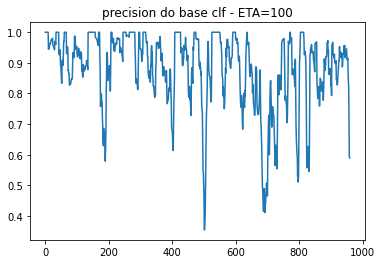

In [13]:

for metric in metrics:
    print(f'{metric} - expected: {expected_score[metric]} - mean {meta_base[metric].mean()}')

metric = 'precision'
meta_base[metric].plot()
plt.title(f"{metric} do base clf - ETA={ETA}")

## Train meta model

In [14]:
import lightgbm as ltb

models = {}

def drop_other_metrics(df, metric):
    cols_to_drop = [col for col in metrics if col != metric]
    return df.drop(cols_to_drop, axis=1)

def _get_train_test_data(df, y_col, train_size=META_TRAIN_SIZE):
    X = df.drop(y_col, axis=1)
    y = df[y_col]
    return train_test_split(X, y, train_size=train_size, random_state=R_STATE, shuffle=False)

def train_meta_regressor(df, y_col, idx, title=None, subplot_shape=(2, 3)):
    if not title:
        title=y_col

    X_train, X_test, y_train, y_test = _get_train_test_data(df, y_col)

    model = ltb.LGBMRegressor(num_leaves=21, max_depth=6)
    model.fit(X_train, y_train)
    predicted_y = model.predict(X_test)

    r2 = performance.evaluate(y_test, predicted_y, 'r2')
    mse = performance.evaluate(y_test, predicted_y, 'mse')
    print(f'{title}: r2={r2}, mse={mse}')
    x = range(len(y_test))

    plt.subplot(*subplot_shape, idx)
    plt.plot(x, y_test, label="expected")
    plt.plot(x, predicted_y, label="predicted")
    plt.title(title)
    plt.legend()

    return model


## Últimos scores como meta features - teste de delay

Delay=10: r2=0.8493072787296583, mse=0.0012222701056909307
Delay=20: r2=0.6633303977769897, mse=0.002655590612521139
Delay=30: r2=0.5021515414447646, mse=0.0038368494897181135
Delay=40: r2=0.3494724326989683, mse=0.004963908720126957
Delay=50: r2=0.19628016713883223, mse=0.006148650712713844
Delay=60: r2=0.217645895838815, mse=0.0059338996307484945
Delay=70: r2=0.1705579967807398, mse=0.006232606770993497
Delay=80: r2=0.06542046347585329, mse=0.007046563780714772
Delay=90: r2=0.07835733360146513, mse=0.007011742735597055


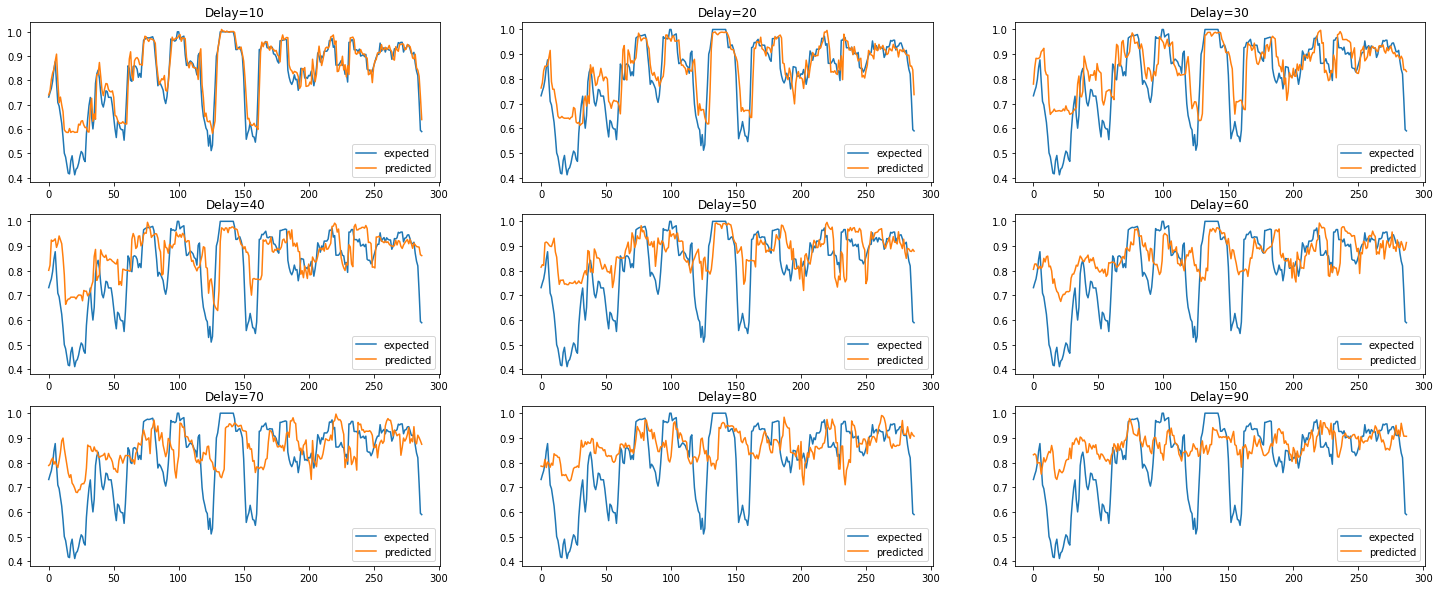

In [15]:
fig = plt.figure(figsize=(25, 10))

delays = range(1, 10)
metric = 'precision'

for idx, delay in enumerate(delays):
    base = meta_base_df.copy()
    base = get_last_scores(base, delay)
    base = drop_other_metrics(base, metric)
    train_meta_regressor(base, metric, idx + 1, title=f"Delay={delay * STEP}", subplot_shape=(3, 3))


###  Métricas

In [16]:
# Standard Deviation

for metric in metrics:
    X_train, X_test, y_train, y_test = _get_train_test_data(meta_base, metric)
    print(f'STD {metric} = {np.std(y_test)}')

STD precision = 0.14977348800030277
STD recall = 0.1517748458265157
STD f1-score = 0.09871422404473758
STD auc = 0.09275793666694745
STD kappa = 0.19252263739356004


In [17]:
# BASELINE

for metric in metrics:
    X_train, X_test, y_train, y_test = _get_train_test_data(meta_base, metric)
    y_pred = [expected_score[metric]] * len(y_test)

    r2 = performance.evaluate(y_test, y_pred, 'r2')
    mse = performance.evaluate(y_test, y_pred, 'mse')
    print(f'BASELINE {metric}: r2={r2}, mse={mse}')

BASELINE precision: r2=-0.07932478519029051, mse=0.007869438334222632
BASELINE recall: r2=-0.00013515305800582134, mse=0.007294253605676089
BASELINE f1-score: r2=-3.824585894252053e-05, mse=0.0030651859607303262
BASELINE auc: r2=-0.0027172103498465106, mse=0.002711534322359026
BASELINE kappa: r2=-0.0010361014375708244, mse=0.01565758838442253


precision: r2=0.5021515414447646, mse=0.0038368494897181135
recall: r2=0.6995878379440774, mse=0.002207967352215612
f1-score: r2=0.4701548838929118, mse=0.001634344659108635
auc: r2=0.45234095304382094, mse=0.0014829115396324717
kappa: r2=0.42726028583830455, mse=0.009010072552616658


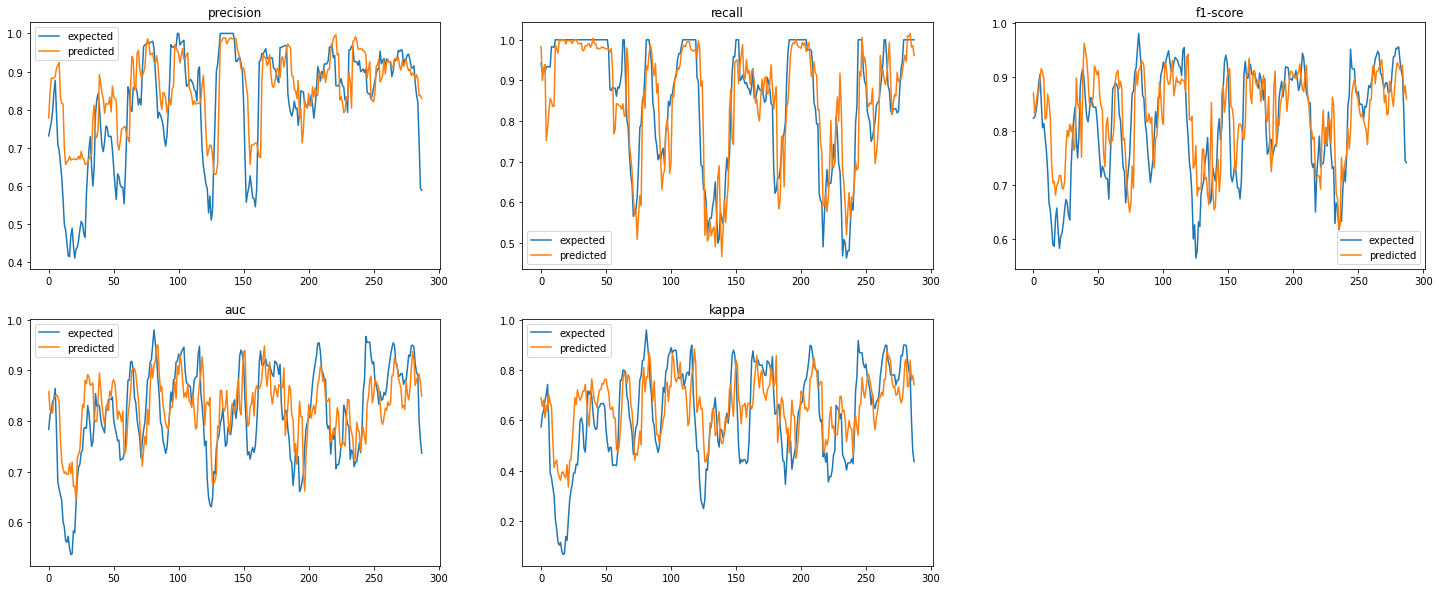

In [18]:
meta_base = meta_base_df.copy()
meta_base = get_last_scores(meta_base, 3)

fig = plt.figure(figsize=(25, 10))
for idx, metric in enumerate(metrics):
    base = drop_other_metrics(meta_base.copy(), metric)
    models[metric] = train_meta_regressor(base, metric, idx + 1)

In [19]:
# import shap

# metric = 'recall'
# base = drop_other_metrics(meta_base.copy(), metric)
# X_train, *args = _get_train_test_data(base, metric)

# shap_values = shap.TreeExplainer(models[metric]).shap_values(X_train)
# shap.summary_plot(shap_values, X_train)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

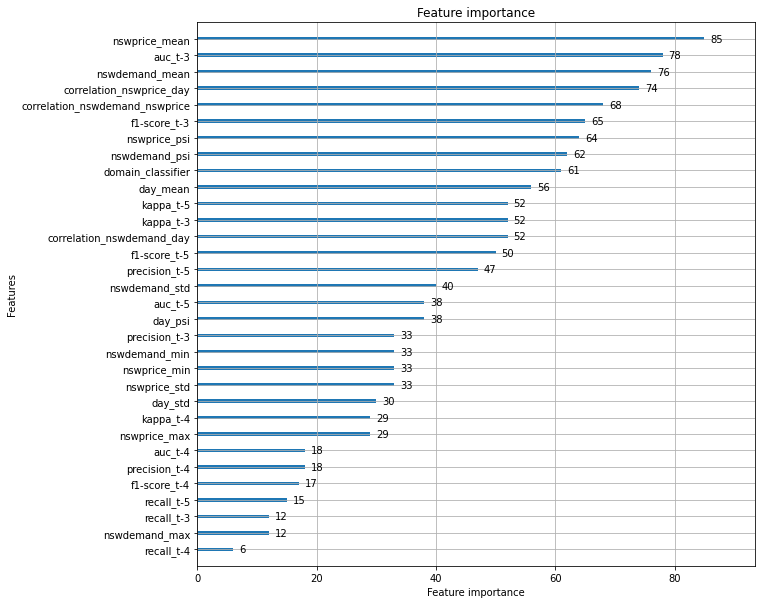

In [20]:
# models[metric].feature_importances_

import lightgbm
lightgbm.plot_importance(models[metric], figsize=(10, 10))